# Predicción de Abandono de Actividades
## Machine Learning para predecir probabilidad de abandono

In [19]:
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve
)

%matplotlib inline

## 1. Extracción de Features

In [20]:
from extract_abandonment_features import extract_abandonment_features

df = extract_abandonment_features()
print(f"\nDatos cargados: {df.shape}")
df.head()

Extrayendo features de abandono desde la base de datos...
Registros extraídos: 5786
Columnas: 21

Features guardadas en: ../output/abandonment_features.csv

Distribución de la variable target:
abandoned
0    3776
1    2010
Name: count, dtype: int64

Tasa de abandono: 34.74%

Datos cargados: (5786, 21)


,activity_uuid,user_id,external_activity_id,abandoned,historical_completion_rate,historical_abandonment_rate,historical_avg_pause_count,historical_avg_duration,difficulty_level,activity_abandonment_rate,...,hour_of_day,day_of_week,days_since_last_activity,avg_days_between_sessions,current_pause_count,cluster_completion_rate,cluster_abandonment_rate,avg_frustration,avg_visual_fatigue,distraction_events_per_hour
0,act_1001_31,1001,102,0,0.7765,0.2235,2.0,4482.1059,3,0.3245,...,9,3,0,3,3,0.778563,0.221437,0.17015,0.3519,0.0301
1,act_1001_35,1001,105,0,0.7765,0.2235,2.0,4482.1059,2,0.3338,...,9,3,0,3,1,0.778563,0.221437,0.17015,0.3519,0.0301
2,act_1001_33,1001,107,1,0.7765,0.2235,2.0,4482.1059,3,0.3758,...,9,3,0,3,3,0.778563,0.221437,0.17015,0.3519,0.0301
3,act_1001_34,1001,101,0,0.7765,0.2235,2.0,4482.1059,1,0.3567,...,9,3,0,3,1,0.778563,0.221437,0.17015,0.3519,0.0301
4,act_1001_32,1001,106,0,0.7765,0.2235,2.0,4482.1059,2,0.3516,...,8,3,0,3,1,0.778563,0.221437,0.17015,0.3519,0.0301


## 2. Análisis Exploratorio

Distribución de la variable target:
abandoned
0    3776
1    2010
Name: count, dtype: int64

Tasa de abandono: 34.74%


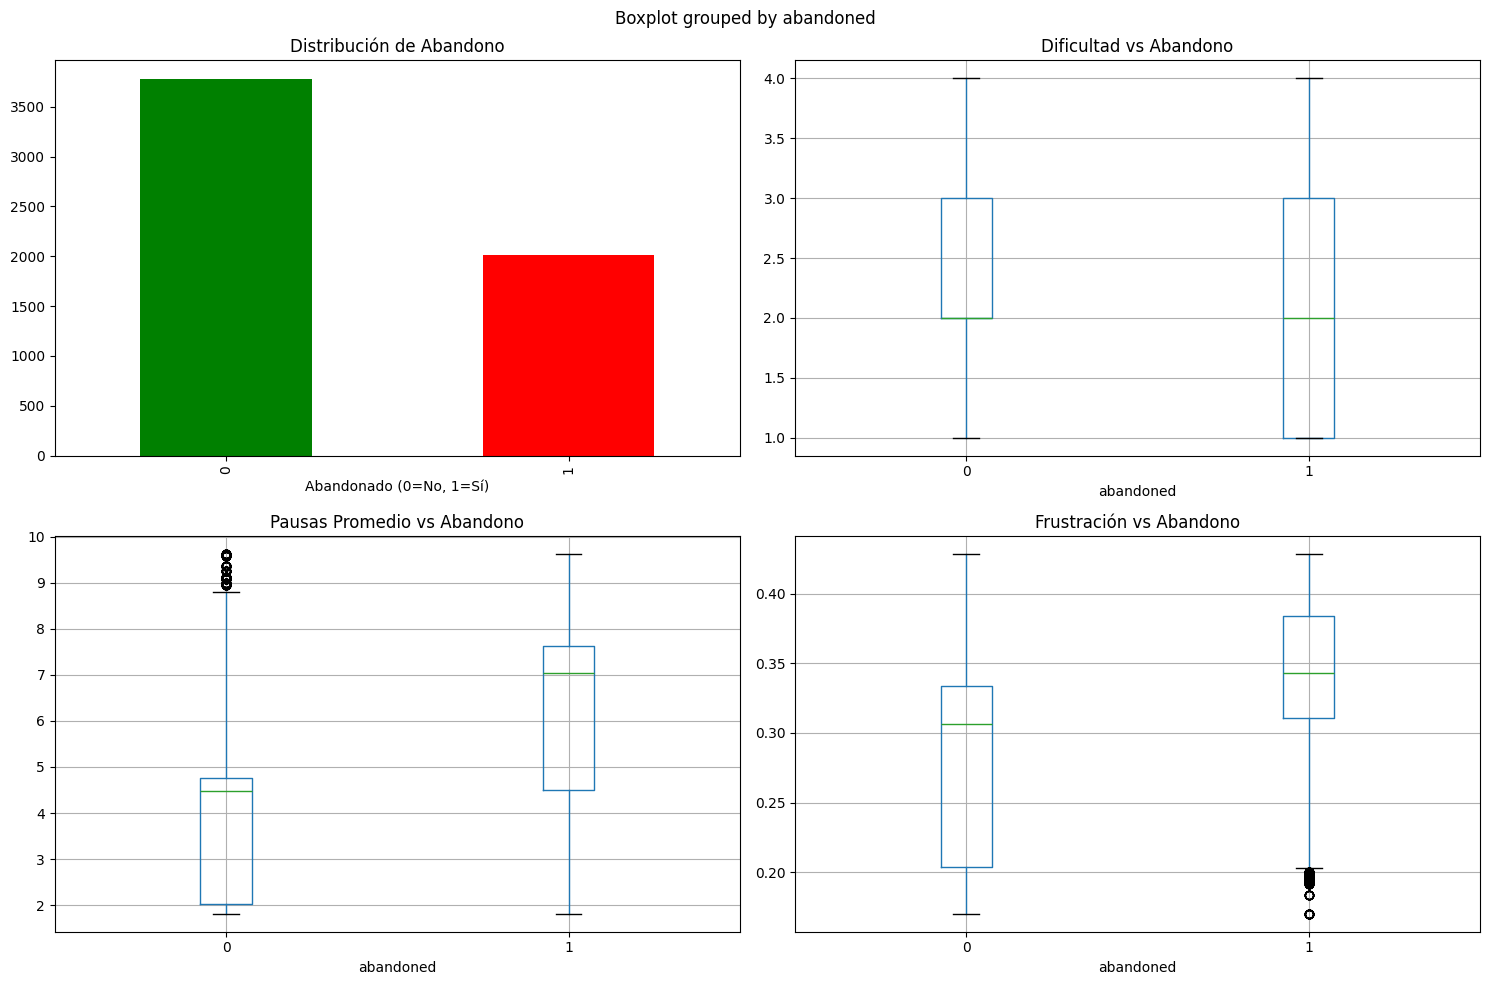

In [21]:
print("Distribución de la variable target:")
print(df['abandoned'].value_counts())
print(f"\nTasa de abandono: {df['abandoned'].mean():.2%}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

df['abandoned'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Distribución de Abandono')
axes[0, 0].set_xlabel('Abandonado (0=No, 1=Sí)')

df.boxplot(column='difficulty_level', by='abandoned', ax=axes[0, 1])
axes[0, 1].set_title('Dificultad vs Abandono')

df.boxplot(column='historical_avg_pause_count', by='abandoned', ax=axes[1, 0])
axes[1, 0].set_title('Pausas Promedio vs Abandono')

df.boxplot(column='avg_frustration', by='abandoned', ax=axes[1, 1])
axes[1, 1].set_title('Frustración vs Abandono')

plt.tight_layout()
plt.show()

## 3. Correlaciones con Target

Top 10 correlaciones positivas con abandono:
historical_abandonment_rate    0.383738
cluster_abandonment_rate       0.360783
historical_avg_duration        0.346885
historical_avg_pause_count     0.341578
avg_frustration                0.332499
current_pause_count            0.302960
activity_abandonment_rate      0.035122
avg_pauses_activity            0.026360
hour_of_day                    0.007668
day_of_week                    0.002527
Name: abandoned, dtype: float64

Top 10 correlaciones negativas con abandono:
avg_pauses_activity            0.026360
hour_of_day                    0.007668
day_of_week                    0.002527
avg_visual_fatigue            -0.002770
distraction_events_per_hour   -0.005954
difficulty_level              -0.014977
cluster_completion_rate       -0.360783
historical_completion_rate    -0.383738
days_since_last_activity            NaN
avg_days_between_sessions           NaN
Name: abandoned, dtype: float64


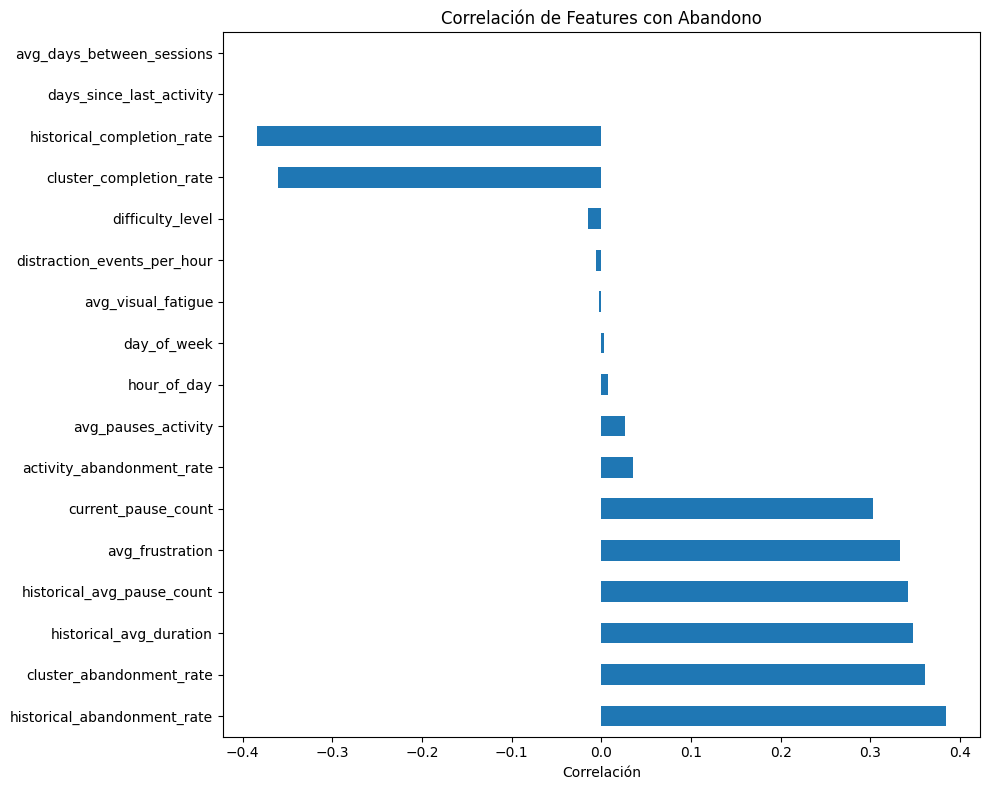

In [22]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['activity_uuid', 'user_id', 'external_activity_id']]

correlations = df[numeric_cols].corr()['abandoned'].sort_values(ascending=False)

print("Top 10 correlaciones positivas con abandono:")
print(correlations.head(11)[1:])

print("\nTop 10 correlaciones negativas con abandono:")
print(correlations.tail(10))

plt.figure(figsize=(10, 8))
correlations[1:].plot(kind='barh')
plt.title('Correlación de Features con Abandono')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()

## 4. Entrenamiento de Modelos

In [23]:
print("Ejecutando entrenamiento completo...")
print("Esto puede tomar varios minutos.")
print("="*60)

%run ../scripts/train_abandonment_model.py

Ejecutando entrenamiento completo...
Esto puede tomar varios minutos.
Datos cargados: (5786, 21)

Features seleccionadas: 17
Target distribution:
abandoned
0    3776
1    2010
Name: count, dtype: int64
Abandonment rate: 34.74%

Train set: (4628, 17)
Test set: (1158, 17)

ENTRENANDO RANDOM FOREST

Métricas en Test Set:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       756
           1       0.51      0.54      0.52       402

    accuracy                           0.66      1158
   macro avg       0.63      0.63      0.63      1158
weighted avg       0.67      0.66      0.66      1158

ROC-AUC: 0.6723
F1-Score: 0.5249

ENTRENANDO XGBOOST

Métricas en Test Set:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       756
           1       0.48      0.57      0.52       402

    accuracy                           0.64      1158
   macro avg       0.61      0.62      0.62      1158
weigh

<Figure size 640x480 with 0 Axes>

## 5. Análisis de Resultados

In [24]:
import json
import joblib

with open('../models/abandonment_metadata.json', 'r') as f:
    metadata = json.load(f)

print("METADATA DEL MODELO:")
print("="*60)
print(f"Tipo de modelo: {metadata['model_type']}")
print(f"Número de features: {metadata['n_features']}")
print(f"Entrenado el: {metadata['trained_on']}")
print(f"\nMétricas:")
for metric, value in metadata['metrics'].items():
    print(f"  {metric}: {value:.4f}")

METADATA DEL MODELO:
Tipo de modelo: Random Forest
Número de features: 17
Entrenado el: 2025-12-09T09:13:55.286245

Métricas:
  roc_auc: 0.6723
  f1_score: 0.5249
  precision: 0.5131
  recall: 0.5373


## 6. Visualización de Resultados

Feature Importance:


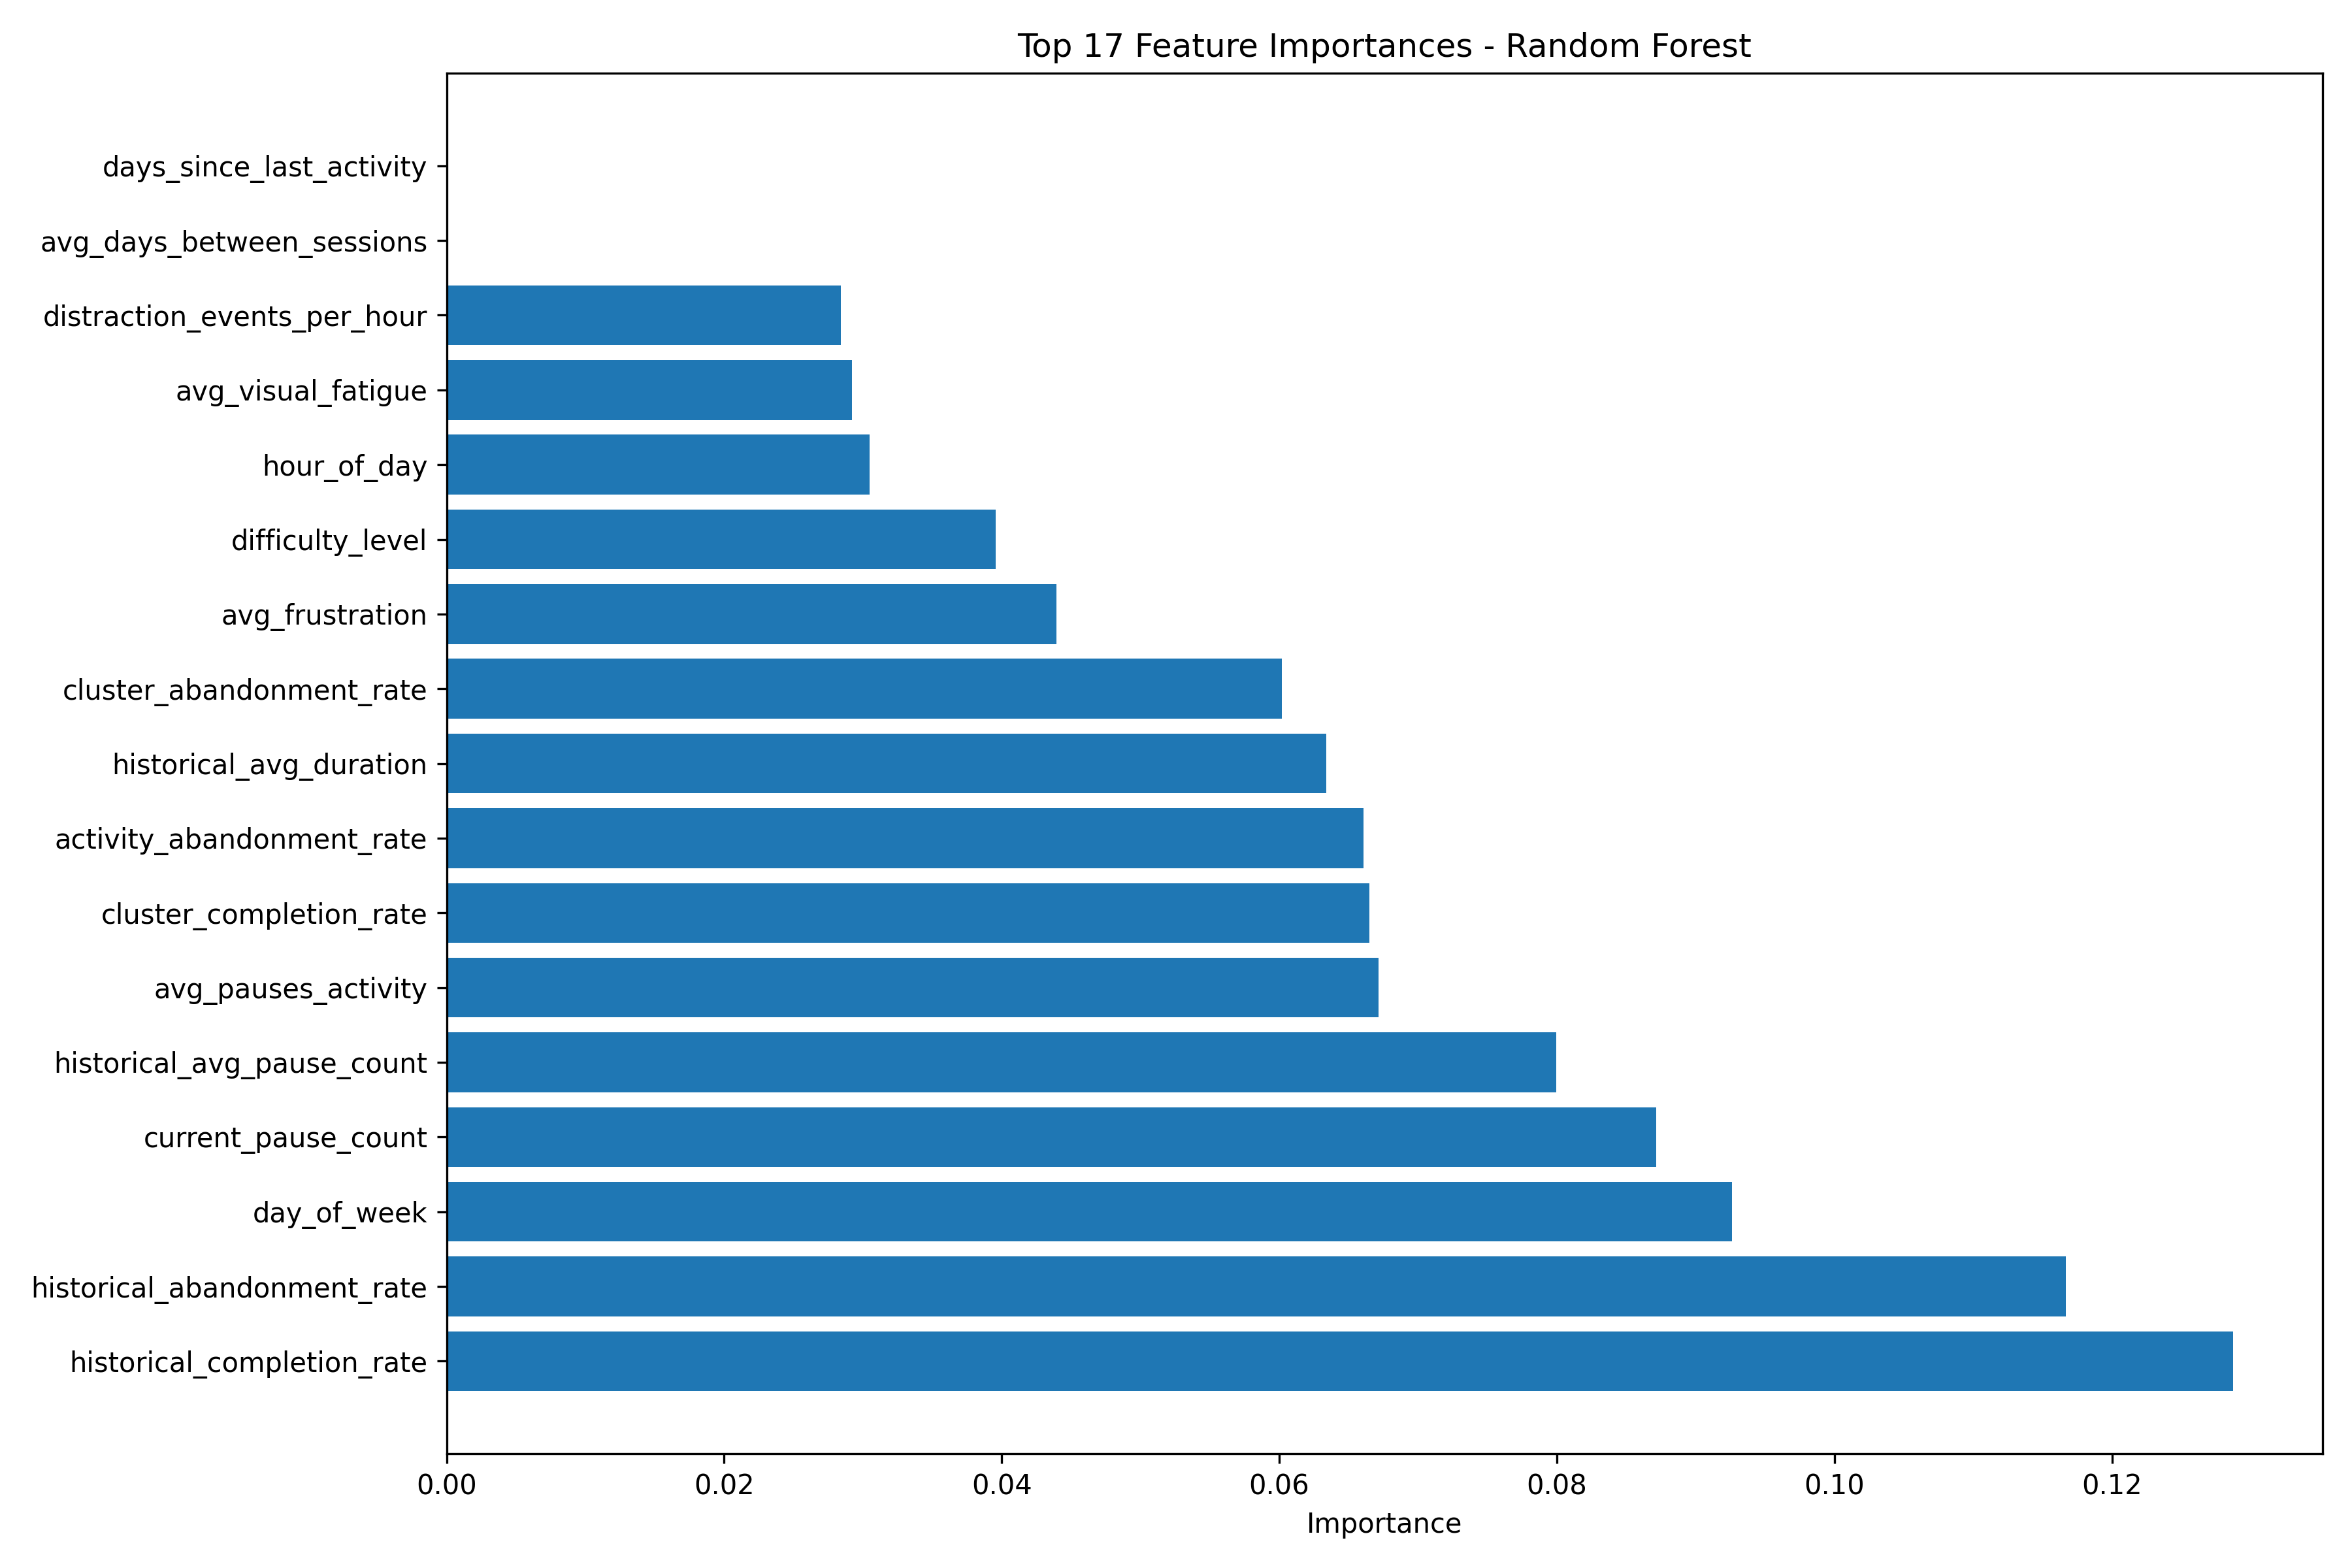


ROC Curves:


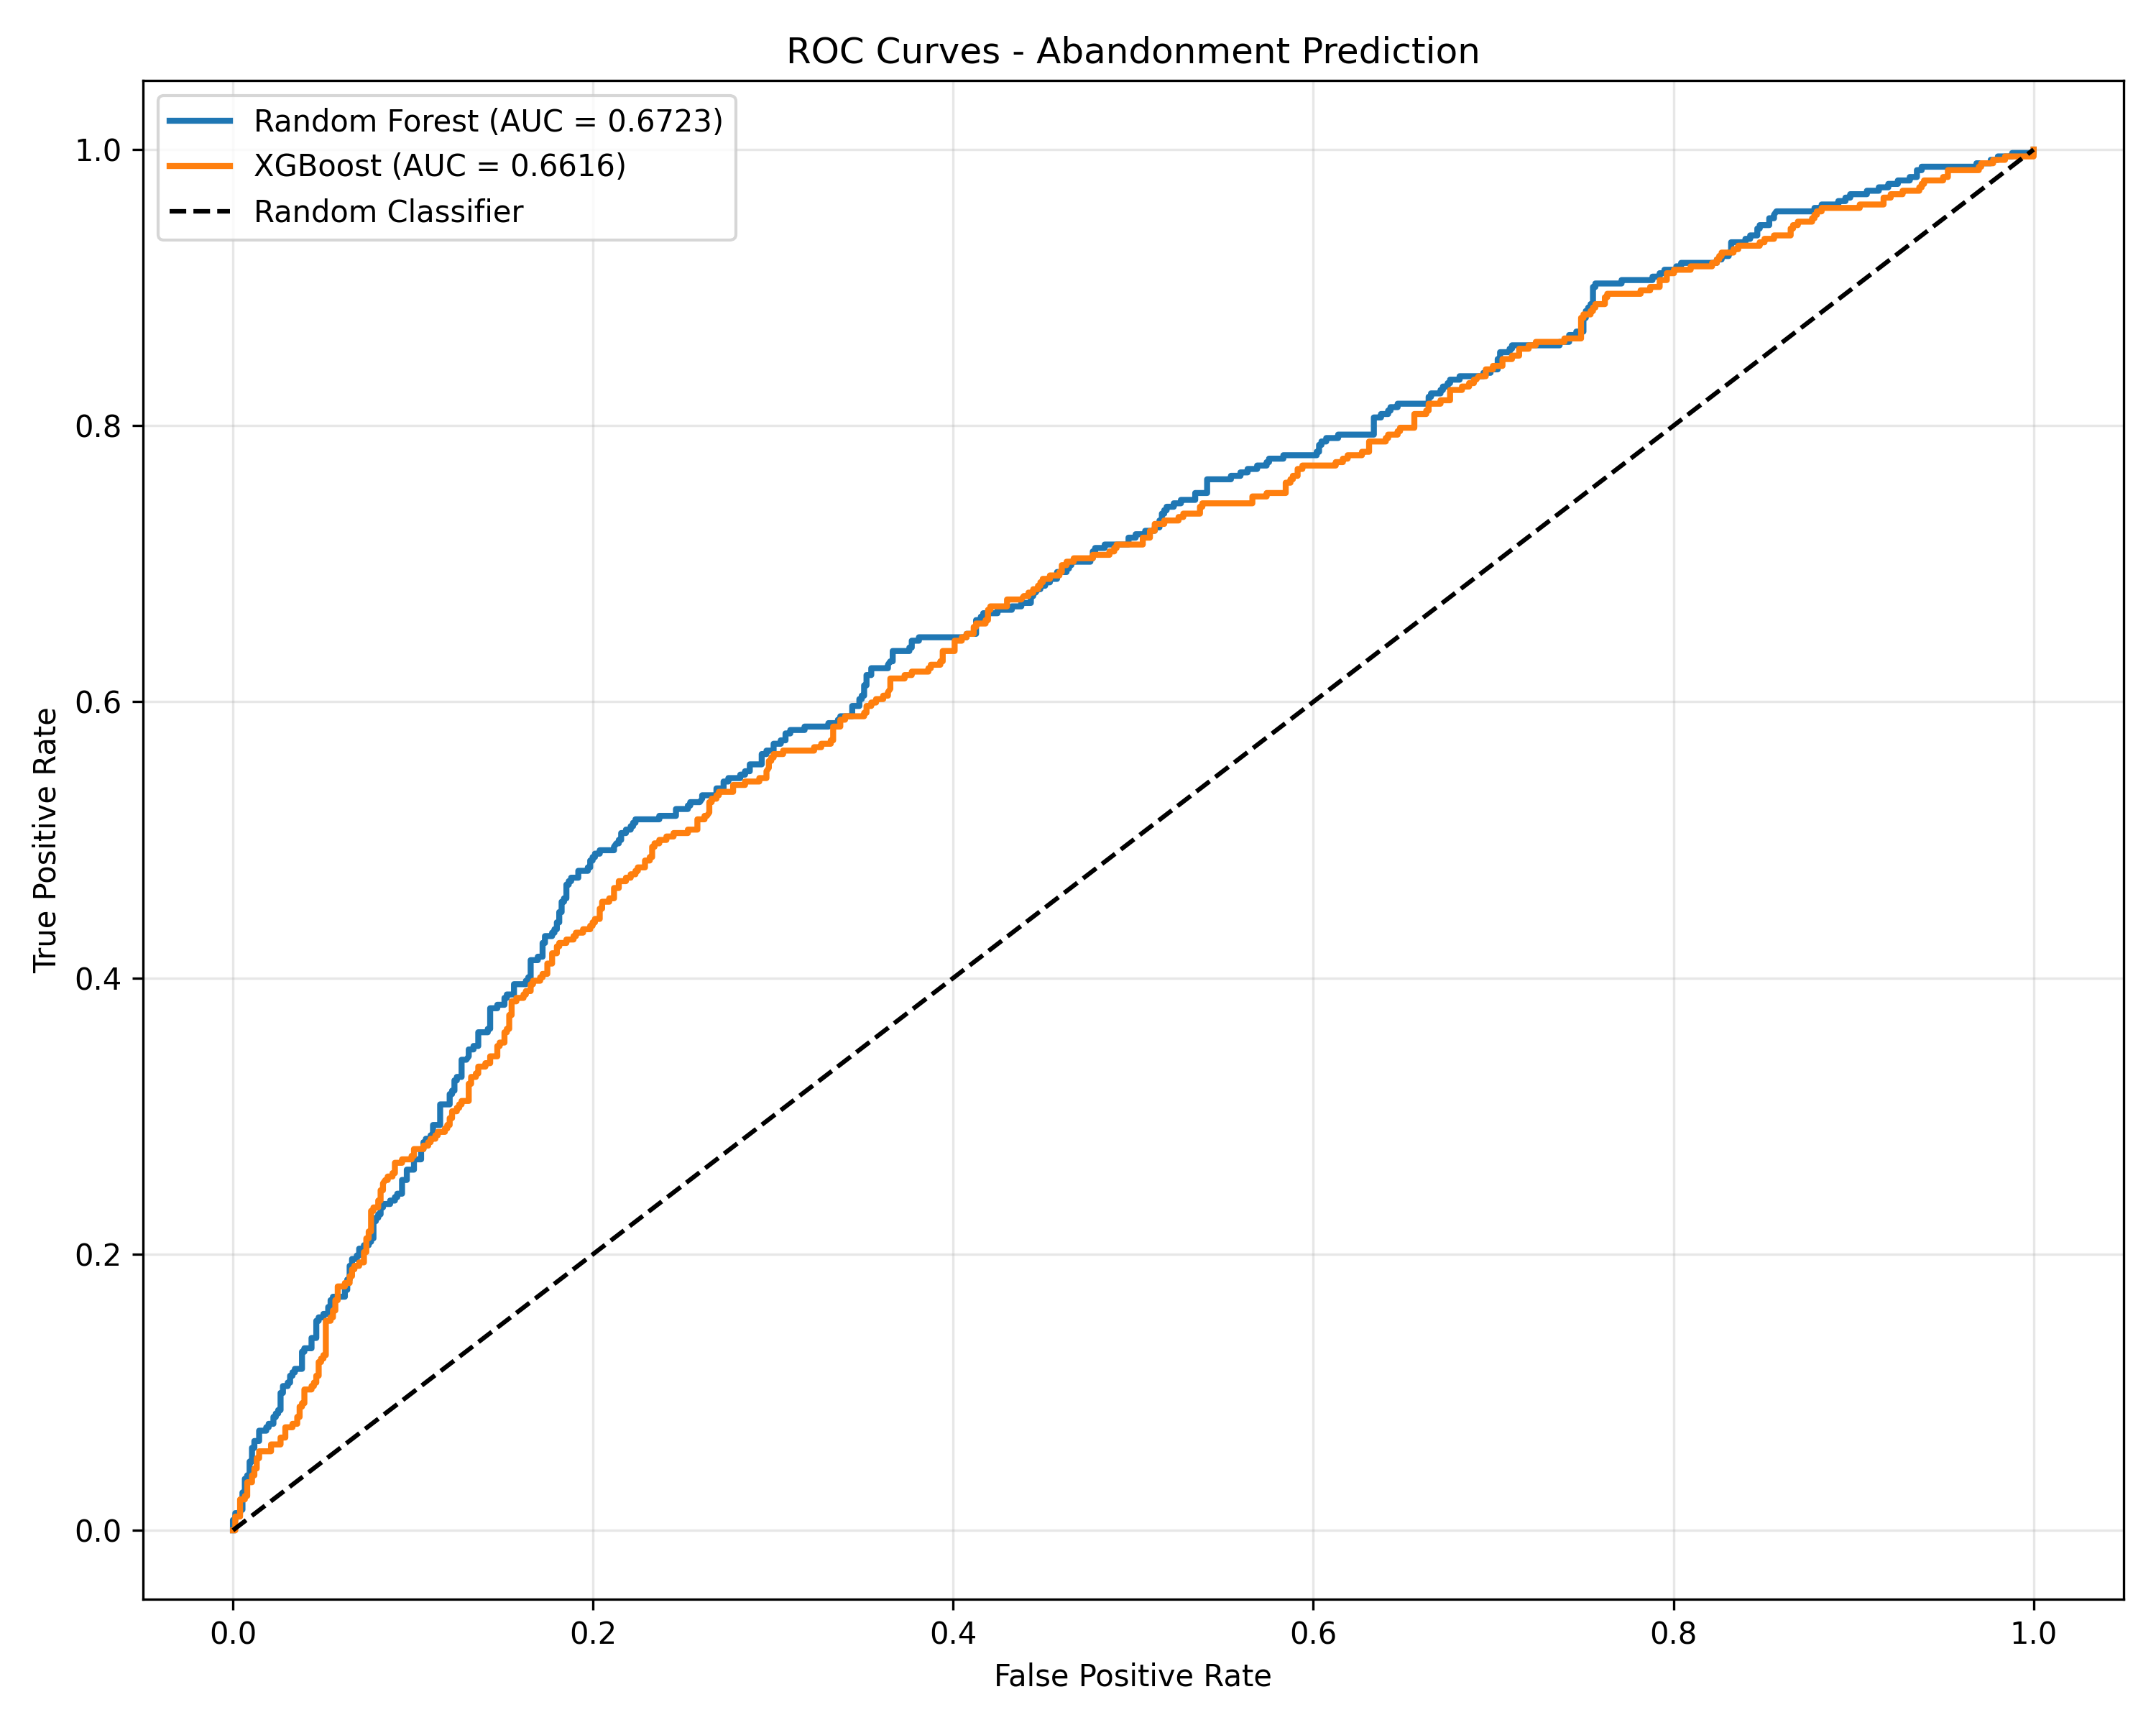


Confusion Matrix:


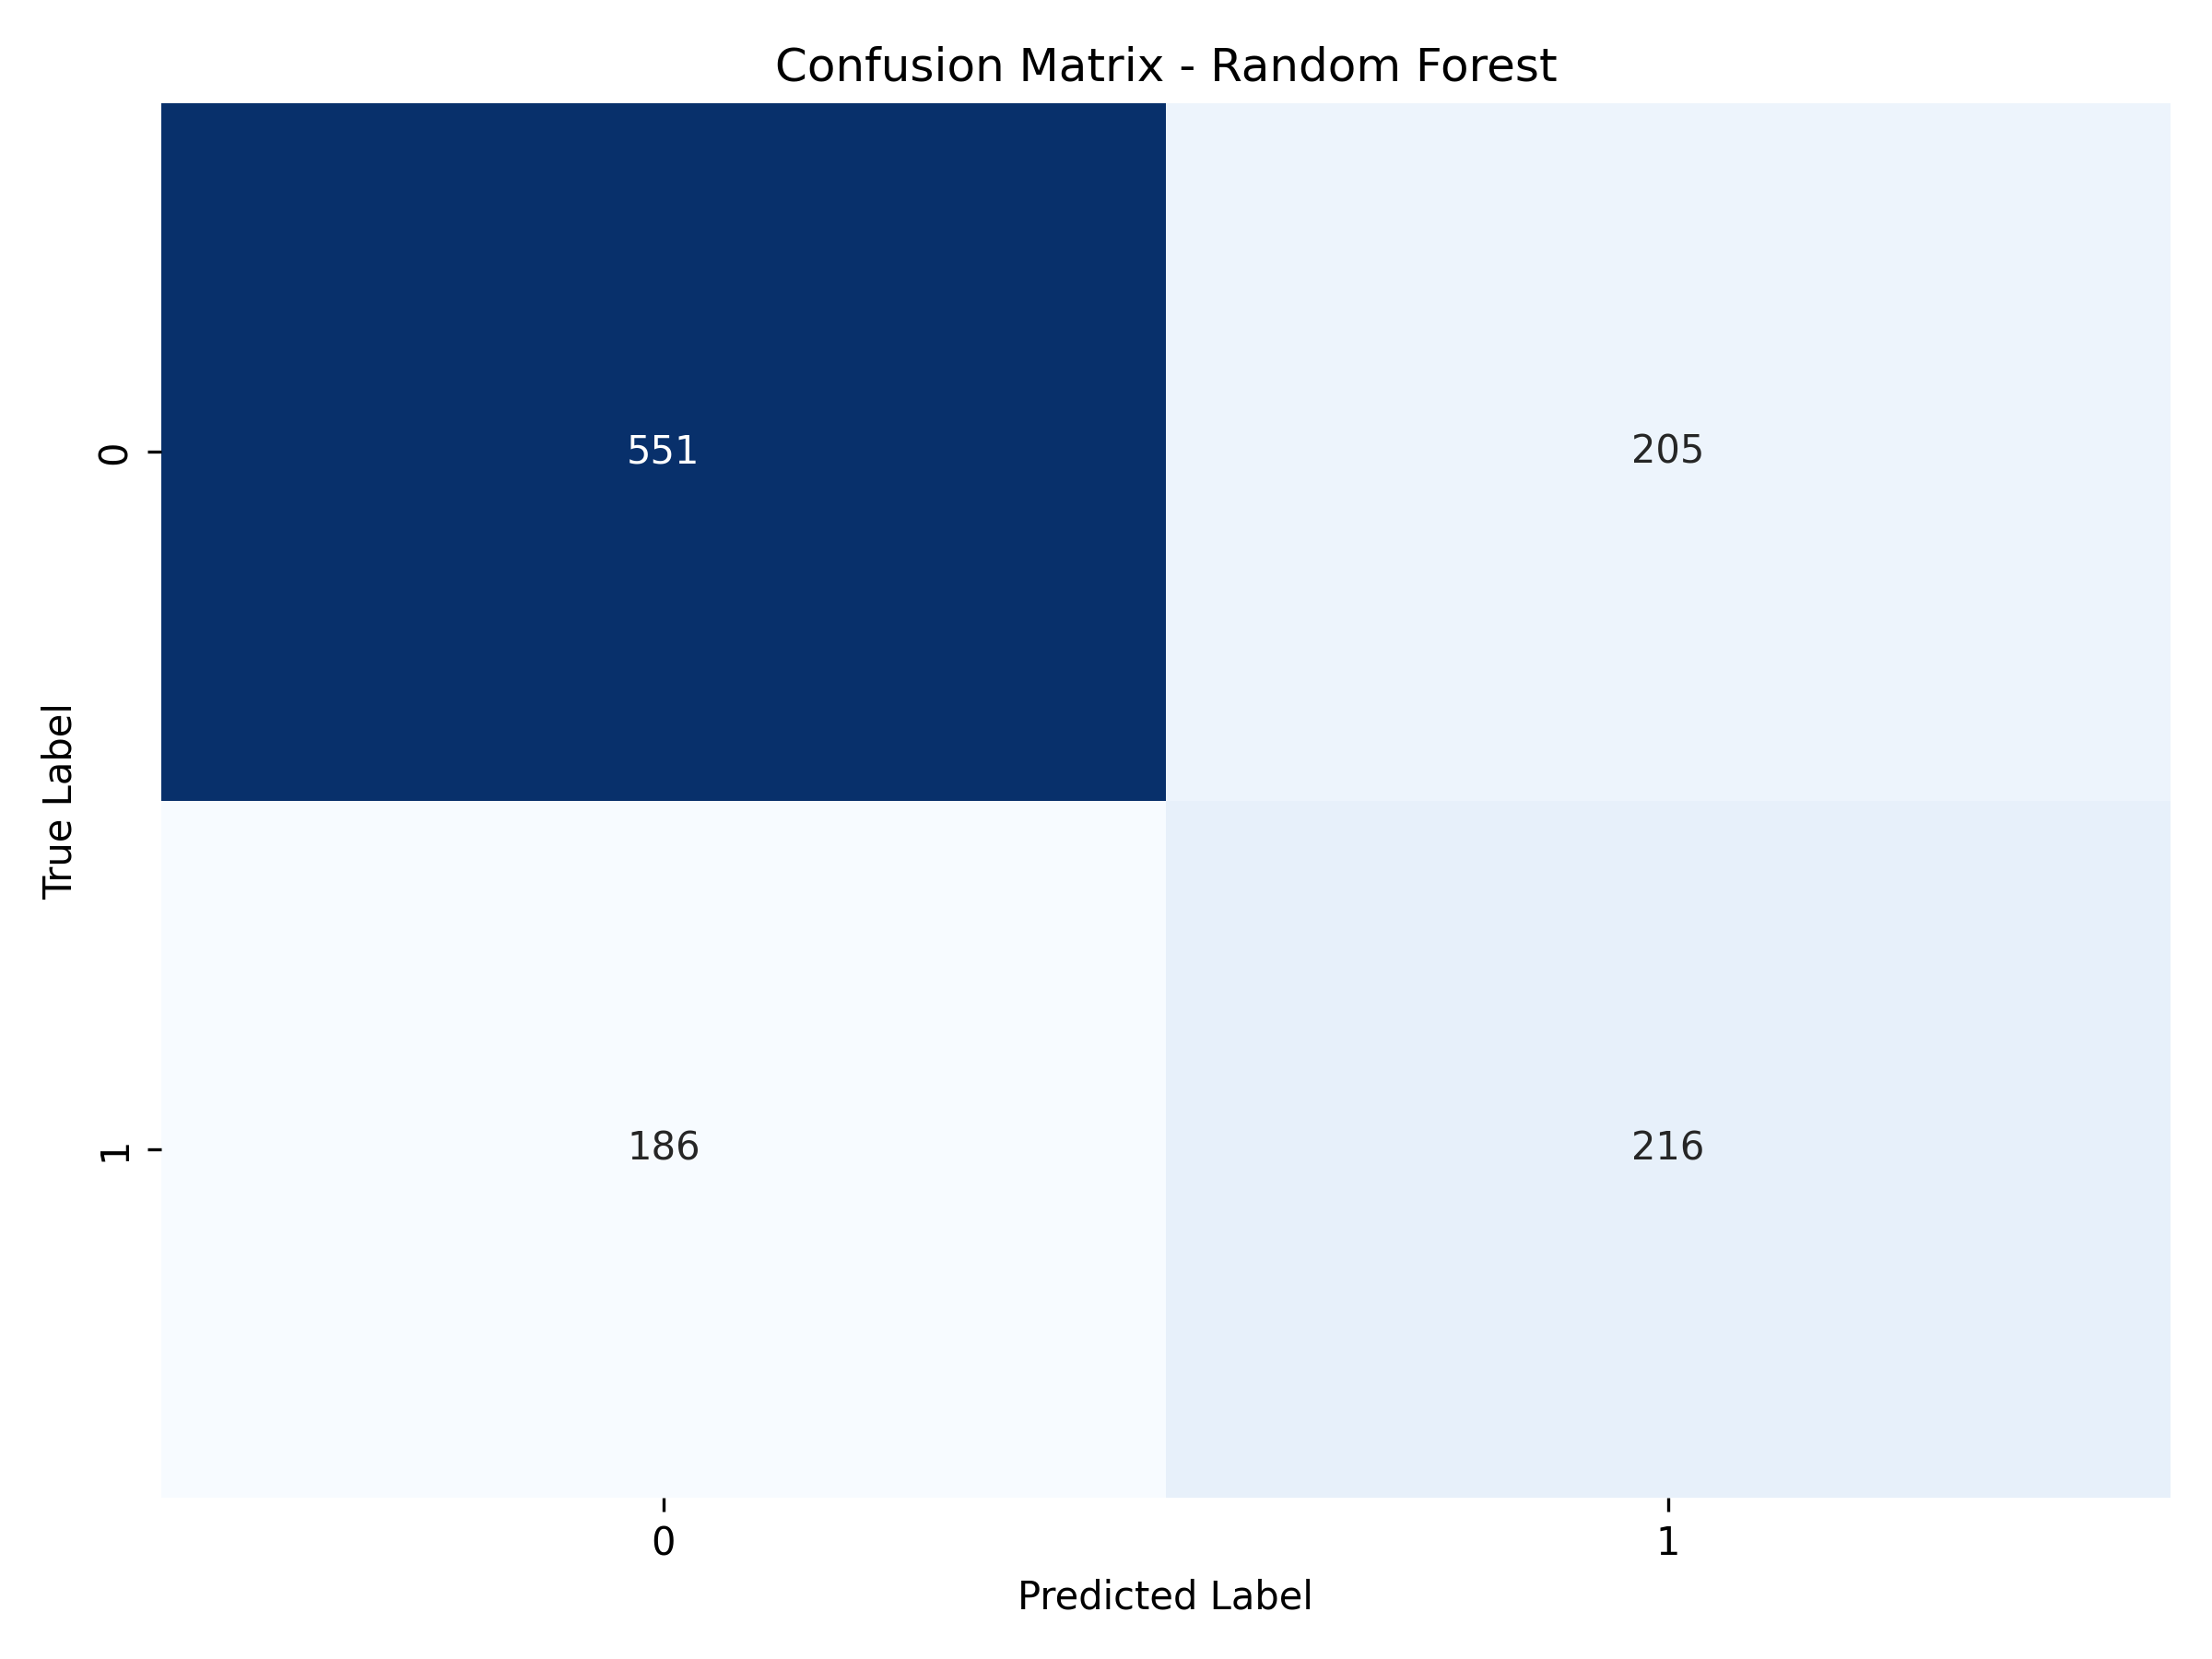

In [25]:
from IPython.display import Image, display

print("Feature Importance:")
display(Image('../output/feature_importance_random_forest.png'))

print("\nROC Curves:")
display(Image('../output/roc_curves_abandonment.png'))

print("\nConfusion Matrix:")
display(Image('../output/confusion_matrix_random_forest.png'))

## 7. Predicciones de Ejemplo

In [26]:
from predict_abandonment import predict_abandonment, predict_for_user_activity

print("EJEMPLO 1: Usuario con alta probabilidad de abandono")
print("="*60)

high_risk_features = {
    'historical_completion_rate': 0.35,
    'historical_abandonment_rate': 0.65,
    'historical_avg_pause_count': 8.5,
    'historical_avg_duration': 4.2,
    'difficulty_level': 4,
    'activity_abandonment_rate': 0.55,
    'avg_pauses_activity': 7.1,
    'hour_of_day': 22,
    'day_of_week': 1,
    'days_since_last_activity': 7,
    'avg_days_between_sessions': 5.5,
    'current_pause_count': 9,
    'cluster_completion_rate': 0.40,
    'cluster_abandonment_rate': 0.60,
    'avg_frustration': 0.82,
    'avg_visual_fatigue': 0.45,
    'distraction_events_per_hour': 12.5
}

result = predict_abandonment(high_risk_features)
print(json.dumps(result, indent=2))

print("\n" + "="*60)
print("EJEMPLO 2: Usuario con baja probabilidad de abandono")
print("="*60)

low_risk_features = {
    'historical_completion_rate': 0.85,
    'historical_abandonment_rate': 0.15,
    'historical_avg_pause_count': 2.5,
    'historical_avg_duration': 12.2,
    'difficulty_level': 1,
    'activity_abandonment_rate': 0.15,
    'avg_pauses_activity': 2.1,
    'hour_of_day': 10,
    'day_of_week': 3,
    'days_since_last_activity': 1,
    'avg_days_between_sessions': 2.5,
    'current_pause_count': 1,
    'cluster_completion_rate': 0.80,
    'cluster_abandonment_rate': 0.20,
    'avg_frustration': 0.25,
    'avg_visual_fatigue': 0.10,
    'distraction_events_per_hour': 2.5
}

result = predict_abandonment(low_risk_features)
print(json.dumps(result, indent=2))

EJEMPLO 1: Usuario con alta probabilidad de abandono


c:\Users\JulioC\Desktop\proyecto\ml\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{
  "will_abandon": true,
  "abandonment_probability": 0.5102066995738973,
  "risk_level": "MEDIUM",
  "recommendation": "Probabilidad media de abandono. Usuario inactivo, enviar recordatorio."
}

EJEMPLO 2: Usuario con baja probabilidad de abandono
{
  "will_abandon": false,
  "abandonment_probability": 0.19746295066844458,
  "risk_level": "LOW",
  "recommendation": "Baja probabilidad de abandono. Usuario estable."
}


c:\Users\JulioC\Desktop\proyecto\ml\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 8. Análisis de Distribución de Riesgos

c:\Users\JulioC\Desktop\proyecto\ml\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Distribución de niveles de riesgo:
risk_level
LOW       2919
MEDIUM    1938
HIGH       929
Name: count, dtype: int64

Probabilidad promedio de abandono: 43.67%


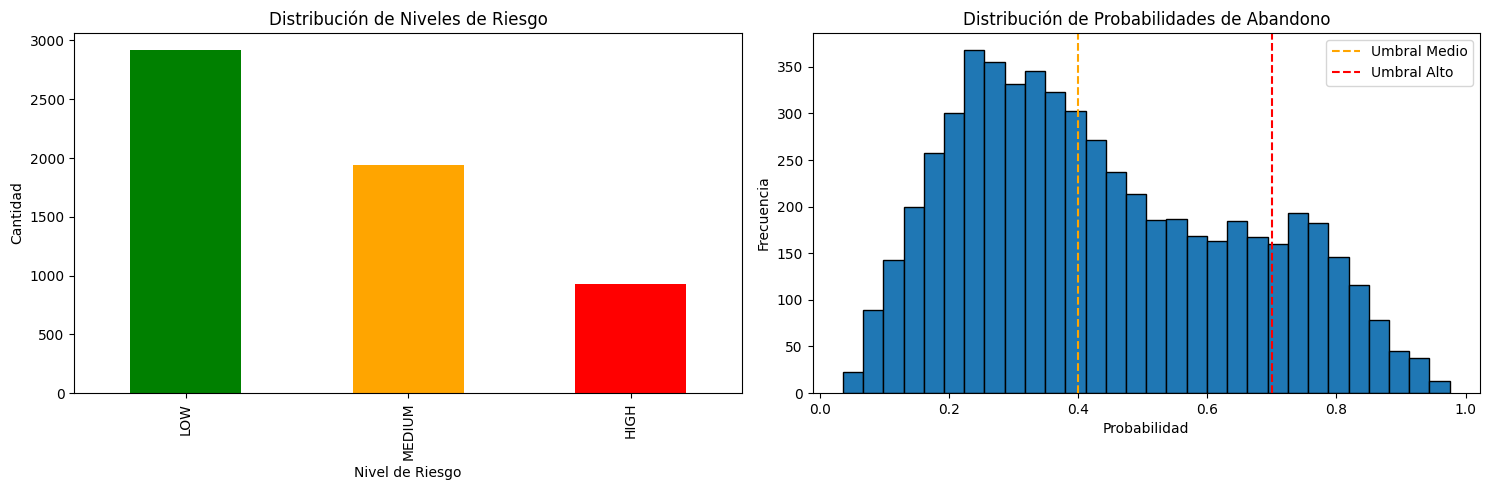


Top 10 usuarios con mayor riesgo:
      user_id  abandonment_probability risk_level
5142     1083                 0.975400       HIGH
5179     1084                 0.969681       HIGH
5160     1083                 0.964656       HIGH
5150     1083                 0.962360       HIGH
5184     1084                 0.961799       HIGH
5138     1083                 0.961001       HIGH
5221     1084                 0.955476       HIGH
4431     1066                 0.952596       HIGH
4408     1066                 0.948448       HIGH
4411     1066                 0.946702       HIGH


In [27]:
from predict_abandonment import batch_predict

df_test = pd.read_csv('../output/abandonment_features.csv')
predictions = batch_predict(df_test)

print("Distribución de niveles de riesgo:")
print(predictions['risk_level'].value_counts())
print(f"\nProbabilidad promedio de abandono: {predictions['abandonment_probability'].mean():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

predictions['risk_level'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
axes[0].set_title('Distribución de Niveles de Riesgo')
axes[0].set_xlabel('Nivel de Riesgo')
axes[0].set_ylabel('Cantidad')

axes[1].hist(predictions['abandonment_probability'], bins=30, edgecolor='black')
axes[1].set_title('Distribución de Probabilidades de Abandono')
axes[1].set_xlabel('Probabilidad')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(0.4, color='orange', linestyle='--', label='Umbral Medio')
axes[1].axvline(0.7, color='red', linestyle='--', label='Umbral Alto')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nTop 10 usuarios con mayor riesgo:")
high_risk = predictions.nlargest(10, 'abandonment_probability')
print(high_risk[['user_id', 'abandonment_probability', 'risk_level']])

## 9. Conclusiones

In [28]:
print("CONCLUSIONES:")
print("="*60)
print(f"1. Modelo entrenado: {metadata['model_type']}")
print(f"2. ROC-AUC: {metadata['metrics']['roc_auc']:.4f}")
print(f"3. F1-Score: {metadata['metrics']['f1_score']:.4f}")
print(f"4. Usuarios de alto riesgo: {(predictions['risk_level'] == 'HIGH').sum()}")
print(f"5. Usuarios de riesgo medio: {(predictions['risk_level'] == 'MEDIUM').sum()}")
print(f"6. Usuarios de bajo riesgo: {(predictions['risk_level'] == 'LOW').sum()}")
print("\nEl modelo puede predecir con precisión qué usuarios tienen alta")
print("probabilidad de abandonar actividades, permitiendo intervenciones preventivas.")

CONCLUSIONES:
1. Modelo entrenado: Random Forest
2. ROC-AUC: 0.6723
3. F1-Score: 0.5249
4. Usuarios de alto riesgo: 929
5. Usuarios de riesgo medio: 1938
6. Usuarios de bajo riesgo: 2919

El modelo puede predecir con precisión qué usuarios tienen alta
probabilidad de abandonar actividades, permitiendo intervenciones preventivas.
